In [1]:
import numpy as np
import os
import pandas as pd
import glob
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = 'data'
performance_path = os.path.join(data_path, 'performance', 'final_classifier_grid')
config_path = os.path.join(data_path, 'config', 'grid', 'final_classifier')
figure_path = os.path.join(data_path, 'figures')

In [3]:
def path_split(x):
    x = x.replace('/', ' ').split()
    return x

In [4]:
## Load group maps
label_path = os.path.join(data_path, 'labels')
os.listdir(label_path)
pd.read_csv(os.path.join(label_path, 'race_eth_map.csv'))
group_map_df = pd.concat(
    {key: pd.read_csv(os.path.join(label_path, '{}_map.csv'.format(key)))
          for key in ['age', 'gender', 'race_eth']}). \
        reset_index(1, drop = True). \
        rename_axis(index = 'sensitive_variable'). \
        rename(columns = {'category_id' : 'group', 'categories' : 'group_name'})

In [5]:
## Load the evaluation results
files_eval = glob.glob(os.path.join(performance_path, '**', '*_eval.csv'), recursive=True)
df_eval = pd.concat({(file, path_split(file)[-4], path_split(file)[-3], path_split(file)[-2]): 
                        pd.read_csv(file) for file in files_eval})
df_eval = df_eval.rename_axis(index = ['file_path', 'outcome', 'sensitive_variable', 'experiment_id', 'index'])
df_eval = df_eval.reset_index([0, 1, 2, 3])

In [6]:
## Load the model config files
files_config = glob.glob(os.path.join(config_path, '**', 'config.csv'), recursive=True)

In [7]:
df_config = pd.concat({(file, path_split(file)[-3], path_split(file)[-2]): 
                pd.read_csv(file) for file in files_config})
df_config = df_config.rename_axis(index = ['file_path', 'outcome', 'sensitive_variable', 'index'])
df_config = df_config.rename(columns = {'id' : 'experiment_id'})
df_config = df_config.reset_index([0, 1, 2])

In [8]:
## Load the files with factual vs counterfactual predictions
files_preds = glob.glob(os.path.join(performance_path, '**', '*_cf_df.csv'), recursive=True)
df_preds = pd.concat({(file, path_split(file)[-4], path_split(file)[-3], path_split(file)[-2]): 
                        pd.read_csv(file) for file in files_preds})

In [9]:
df_preds.head()

phase  y  y_cf  \
data/performance/final_classifier_grid/los/age/... los age 0 0  test  0     0   
                                                             1  test  0     0   
                                                             2  test  0     0   
                                                             3  test  0     0   
                                                             4  test  1     1   

                                                                group  \
data/performance/final_classifier_grid/los/age/... los age 0 0      3   
                                                             1      3   
                                                             2      2   
                                                             3      2   
                                                             4      2   

                                                                group_cf  \
data/performance/final_classifier_grid/los/age/... los age 0 0         0   
                                                             1         0   
                                                             2         0   
                                                             3         0   
                                                             4         0   

                                                                pred_prob_factual  \
data/performance/final_classifier_grid/los/age/... los age 0 0           0.097010   
                                                             1           0.015053   
                                                             2           0.012044   
                                                             3           0.201651   
                                                             4           0.902797   

                                                                pred_prob_cf  \
data/performance/final_classifier_grid/los/age/... los age 0 0      0.056446   
                                                             1      0.011752   
                                                             2      0.008748   
                                                             3      0.148533   
                                                             4      0.904435   

                                                                output_factual  \
data/performance/final_classifier_grid/los/age/... los age 0 0       -2.022694   
                                                             1       -2.604437   
                                                             2       -2.586944   
                                                             3       -1.633199   
                                                             4       -0.011167   

                                                                output_cf  \
data/performance/final_classifier_grid/los/age/... los age 0 0  -2.221776   
                                                             1  -2.693174   
                                                             2  -2.722506   
                                                             3  -1.772977   
                                                             4   0.013584   

                                                                pred_diff  
data/performance/final_classifier_grid/los/age/... los age 0 0  -0.040564  
                                                             1  -0.003300  
                                                             2  -0.003296  
                                                             3  -0.053118  
                                                             4   0.001638

In [10]:
df_preds = df_preds.rename_axis(index = ['file_path', 'outcome', 'sensitive_variable', 'experiment_id', 'index'])
df_preds = df_preds.reset_index([0, 1, 2, 3])
df_preds['experiment_id'] = df_preds['experiment_id'].astype('int')

In [11]:
df_preds = pd.merge(df_preds, group_map_df.reset_index(), how = 'left')
df_preds = pd.merge(df_preds, group_map_df.reset_index(). \
                          rename(columns = {'group' : 'group_cf', 'group_name' : 'group_cf_name'}), how = 'left')

In [12]:
df_preds_temp = df_preds.loc[(df_preds.sensitive_variable == 'race_eth') & 
                            (df_preds.outcome == 'mortality') & 
                            (df_preds.phase == 'test')
                           ]

In [13]:
## Selected hyperparameters
df_config_temp = df_config.loc[
                                (df_config.cf_gradients == False) &
                               (df_config.lambda_final_classifier_cf == 1.0) &
                               (df_config.lr_final_classifier == 1e-3) & 
                               (df_config.weighted == False)
                              ]

In [14]:
df_selected = pd.merge(df_preds_temp, df_config_temp, how = 'inner', on = ['experiment_id', 'outcome', 'sensitive_variable'])


In [15]:
df_selected = df_selected.loc[(df_selected.y == df_selected.y_cf) & (df_selected.y == 0)]

In [16]:
temp = df_selected.groupby(['phase', 'y', 'y_cf', 'group_name', 'group_cf_name', 'lambda_clp'])[['pred_diff']]. \
        agg(lambda x: np.mean(x)). \
        reset_index()
temp. \
    groupby('lambda_clp'). \
    apply(lambda x: x.pivot('group_name', 'group_cf_name', 'pred_diff'))

group_cf_name             Asian     Black  Hispanic     Other   Unknown  \
lambda_clp group_name                                                     
0.00       Asian            NaN -0.001449 -0.001014 -0.000549  0.003948   
           Black       0.000983       NaN  0.000347  0.000281  0.004771   
           Hispanic    0.000707 -0.000719       NaN  0.000221  0.003765   
           Other       0.000991 -0.000473 -0.000487       NaN  0.003560   
           Unknown    -0.005270 -0.008086 -0.011917 -0.006711       NaN   
           White       0.000018 -0.002677 -0.001914 -0.001300  0.004443   
0.01       Asian            NaN  0.000143 -0.001234 -0.001047  0.002615   
           Black      -0.000075       NaN -0.001570 -0.000862  0.003785   
           Hispanic    0.000715  0.000504       NaN -0.000303  0.002902   
           Other       0.000812  0.001060 -0.000380       NaN  0.003139   
           Unknown    -0.004951 -0.007865 -0.009868 -0.008018       NaN   
           White       0.002000  0.001619  0.000519  0.000298  0.003840   
0.10       Asian            NaN -0.000244 -0.001963 -0.000520  0.002534   
           Black       0.000209       NaN -0.001096 -0.000408  0.004269   
           Hispanic    0.001169  0.001045       NaN  0.000464  0.002502   
           Other       0.000727  0.000436 -0.001449       NaN  0.002815   
           Unknown    -0.004491 -0.007019 -0.010786 -0.005270       NaN   
           White       0.000291  0.000025 -0.001892 -0.000702  0.003217   
1.00       Asian            NaN -0.001601 -0.000791 -0.000452  0.001096   
           Black       0.001163       NaN  0.000524  0.000588  0.002404   
           Hispanic    0.000682 -0.000617       NaN  0.000282  0.000829   
           Other       0.000389 -0.000539 -0.000517       NaN  0.000661   
           Unknown    -0.000856 -0.002993 -0.002651 -0.001255       NaN   
           White       0.000579 -0.001101 -0.000468 -0.000043  0.001528   
10.00      Asian            NaN -0.000199 -0.000141 -0.000286  0.000345   
           Black       0.000262       NaN  0.000058 -0.000176  0.001018   
           Hispanic    0.000149 -0.000025       NaN -0.000132  0.000366   
           Other       0.000275  0.000154  0.000134       NaN  0.000528   
           Unknown    -0.000619 -0.000751 -0.000929 -0.001039       NaN   
           White       0.000202 -0.000067 -0.000091 -0.000213  0.000493   

group_cf_name             White  
lambda_clp group_name            
0.00       Asian       0.000336  
           Black       0.000828  
           Hispanic    0.000418  
           Other       0.000973  
           Unknown    -0.007407  
           White            NaN  
0.01       Asian      -0.001168  
           Black      -0.001159  
           Hispanic   -0.000650  
           Other      -0.000257  
           Unknown    -0.009841  
           White            NaN  
0.10       Asian      -0.000297  
           Black       0.000442  
           Hispanic    0.001127  
           Other       0.000161  
           Unknown    -0.006070  
           White            NaN  
1.00       Asian      -0.000376  
           Black       0.000692  
           Hispanic    0.000201  
           Other      -0.000112  
           Unknown    -0.002218  
           White            NaN  
10.00      Asian      -0.000077  
           Black       0.000080  
           Hispanic    0.000045  
           Other       0.000188  
           Unknown    -0.000762  
           White            NaN

In [17]:
temp['color'] = np.where(temp['pred_diff'] >= 0.0, 'blue', 'red')

In [18]:
def draw_line(data = None, color = None, label = None):
    plt.axhline(y = 0, linestyle = 'dashed')

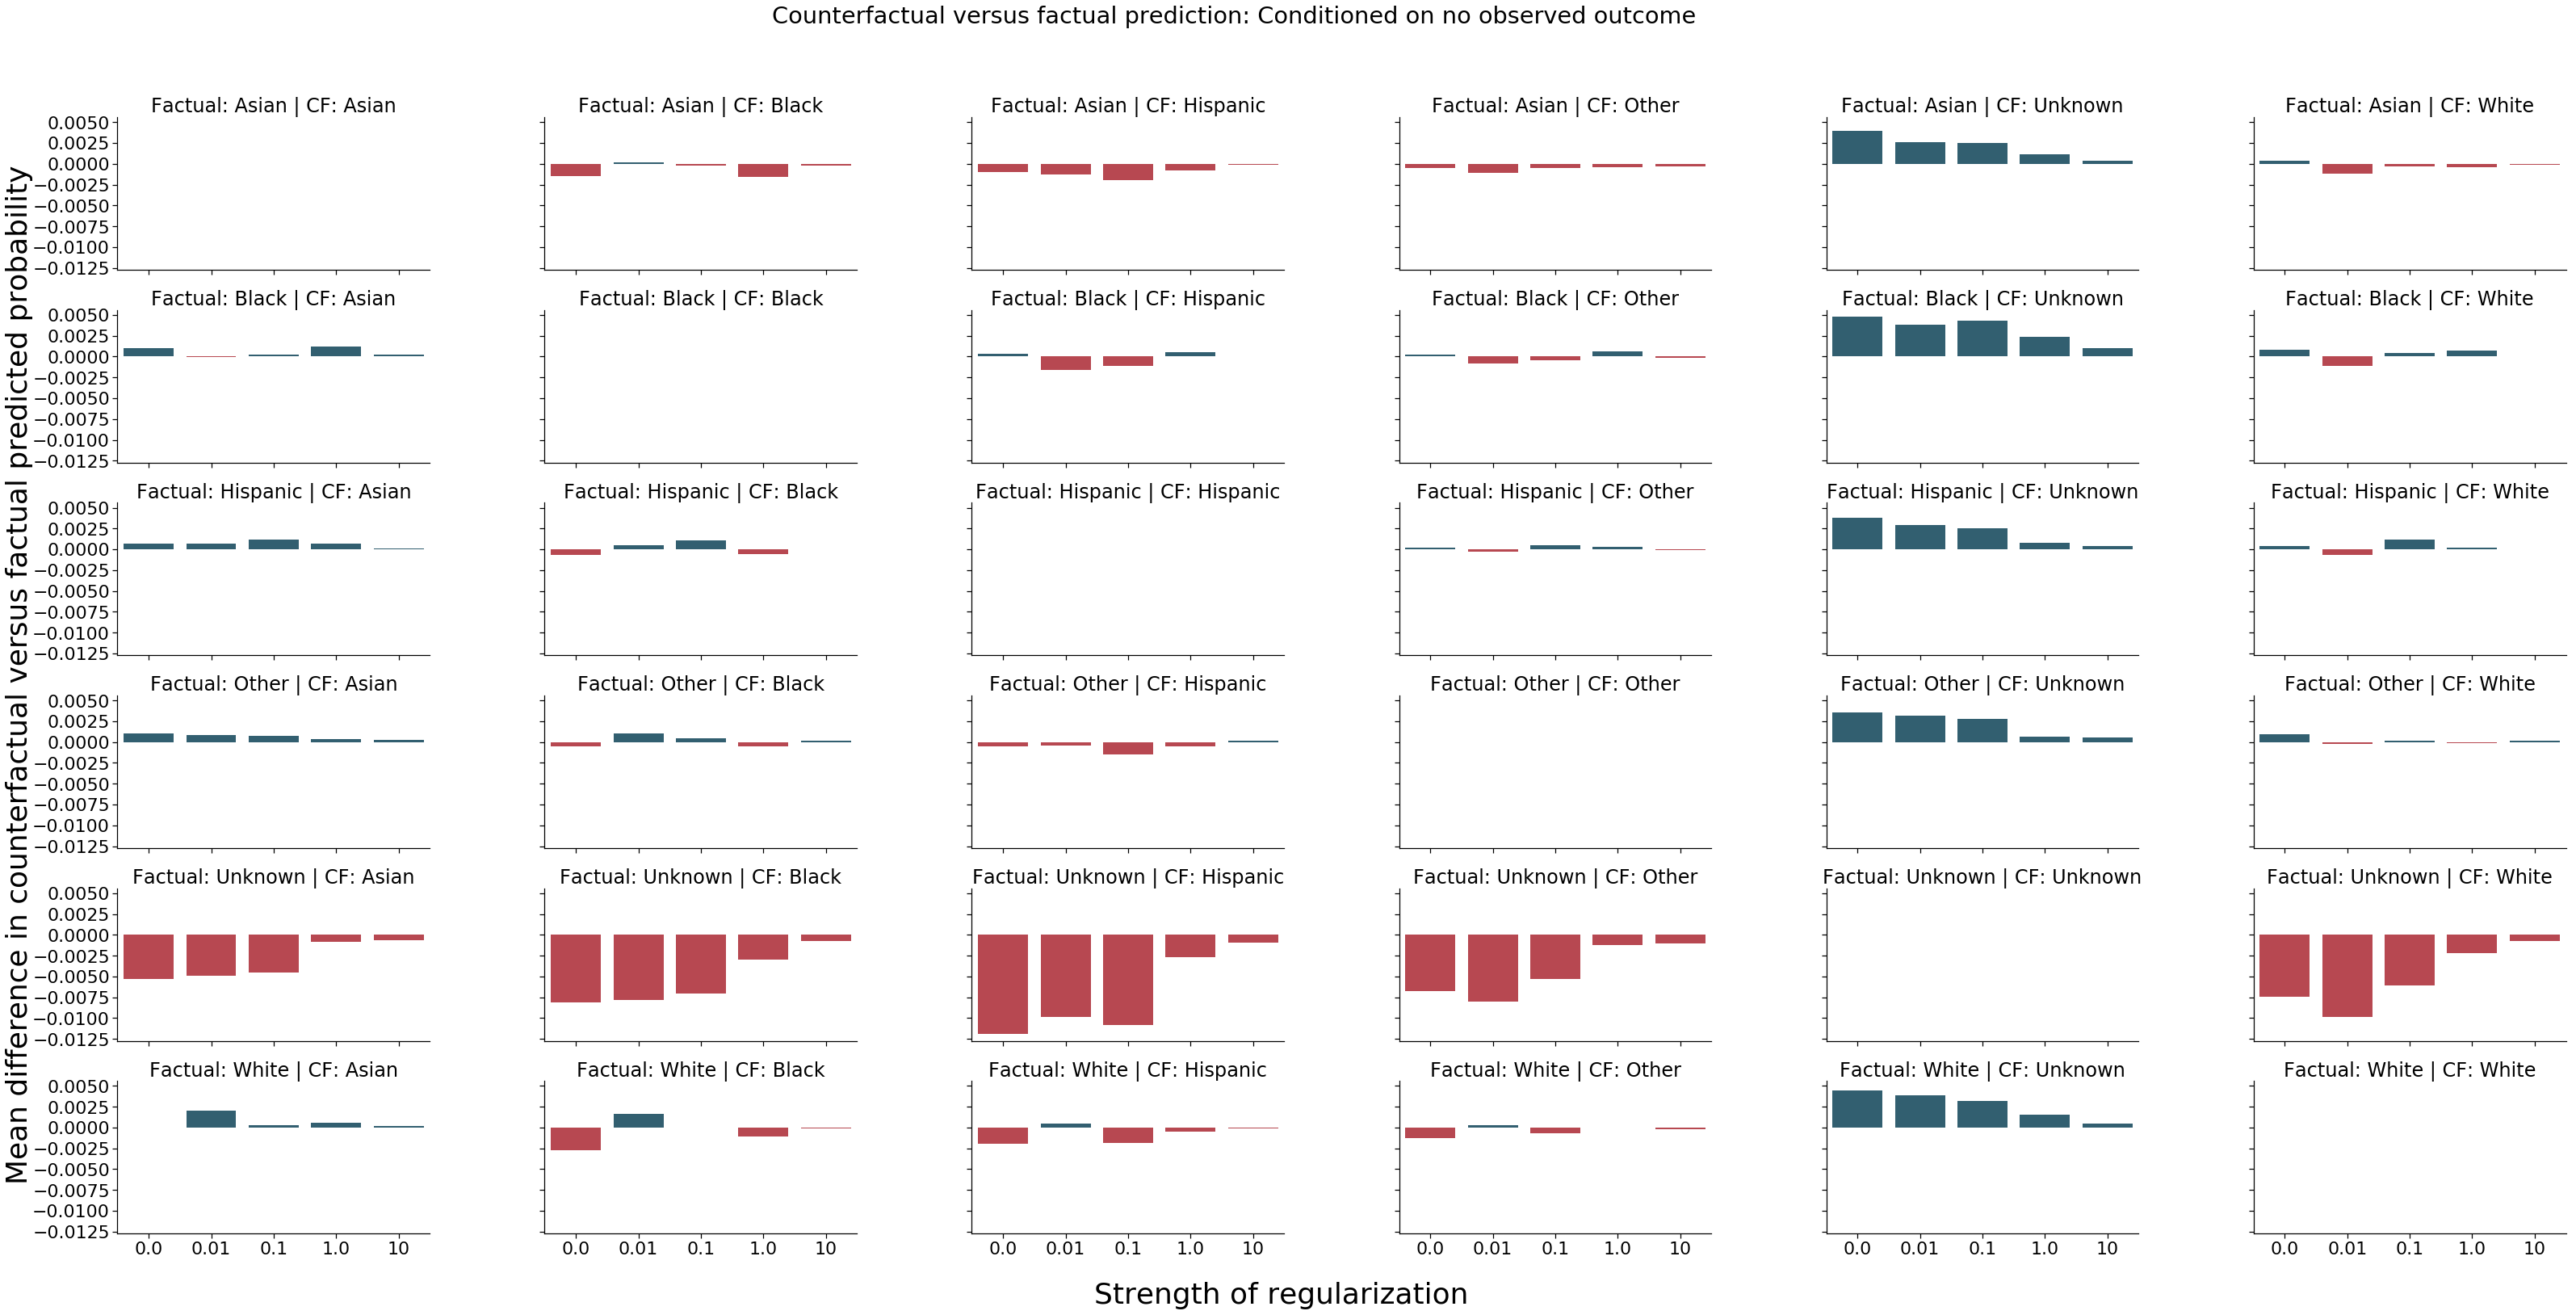

In [20]:
## Selected hyperparameters
# df_config_temp = df_config.loc[(df_config.cf_gradients == True) &
#                                (df_config.lambda_final_classifier_cf == 1.0) &
#                                (df_config.lr_final_classifier == 1e-3) & 
#                                (df_config.weighted == False)
#                               ]

figure_path = os.path.join(data_path, 'figures')
with sns.plotting_context('notebook', font_scale=2):
    g = sns.FacetGrid(temp,
                      hue = 'color',
                      row = "group_name", 
                      col = "group_cf_name", 
                      row_order = ['Asian', 'Black', 'Hispanic', 'Other', 'Unknown', 'White'], 
                      col_order = ['Asian', 'Black', 'Hispanic', 'Other', 'Unknown', 'White'], 
                      hue_order = ['blue', 'red'],
                      palette = {'blue' : '#27647B', 'red' : '#CA3542'},
                      height = 4,
                      aspect = 2
                     )
    
    g.map(sns.barplot, 'lambda_clp', 'pred_diff', order = [0.0, 0.01, 0.1, 1.0, 10])
    plt.subplots_adjust(top = 0.9, left = 0.1, bottom = 0.1)
    g.fig.suptitle('Counterfactual versus factual prediction: Conditioned on no observed outcome')
    g.fig.text(x = 0.45, y = 0.05, 
               s = 'Strength of regularization', 
               rotation = 'horizontal', fontsize=36)
    g.fig.text(x = 0.06, y = 0.85, 
               s = 'Mean difference in counterfactual versus factual predicted probability', 
               rotation = 'vertical', fontsize=36)
    g.set_xlabels('')
    g.set_ylabels('')
    g.set_titles(row_template = 'Factual: {row_name}', col_template = 'CF: {col_name}')
    g.savefig(os.path.join(figure_path, 'test.png'), dpi = 90)

In [21]:
col_order_dict = {'race_eth' : ['Asian', 'Black', 'Hispanic', 'Other', 'Unknown', 'White'],
                 'gender' : ['Female', 'Male'],
                  'age' : group_map_df.loc[group_map_df.index.get_level_values('sensitive_variable') == 'age'].group_name.array
                 }

In [24]:
figure_path = os.path.join(data_path, 'figures', 'bar_plot_pred_diff')
os.makedirs(figure_path, exist_ok = True)

for sensitive_variable in ['race_eth', 'age', 'gender']:
    for outcome in ['mortality', 'los']:
        for y in [0, 1]:
            for y_cf in [0, 1]:
                print(sensitive_variable, outcome, y, y_cf)
                df_preds_temp = df_preds.loc[(df_preds.sensitive_variable == sensitive_variable) & 
                                    (df_preds.outcome == outcome) & 
                                    (df_preds.phase == 'test')
                                   ]
                df_selected = pd.merge(df_preds_temp, df_config_temp, 
                                       how = 'inner', on = ['experiment_id', 'outcome', 'sensitive_variable'])
                df_selected = df_selected.loc[(df_selected.y == y) & (df_selected.y_cf == y_cf)]
                temp = df_selected.groupby(['phase', 
                                            'y', 'y_cf', 
                                            'group_name', 'group_cf_name', 
                                            'lambda_clp'])[['pred_diff']]. \
                    agg(lambda x: np.mean(x)). \
                    reset_index()
                temp['color'] = np.where(temp['pred_diff'] >= 0.0, 'blue', 'red')
                with sns.plotting_context('notebook', font_scale=2):
                    g = sns.FacetGrid(temp,
                                      hue = 'color',
                                      row = "group_name", 
                                      col = "group_cf_name", 
                                      row_order = col_order_dict[sensitive_variable],
                                      col_order = col_order_dict[sensitive_variable],
                                      palette = {'blue' : '#27647B', 'red' : '#CA3542'},
                                      height = 4,
                                      aspect = 2
                                     )

                    g.map(sns.barplot, 'lambda_clp', 'pred_diff', order = [0.0, 0.01, 0.1, 1.0, 10])
                    plt.subplots_adjust(top = 0.9, left = 0.1, bottom = 0.1)
                    g.fig.text(x = 0.45, y = 0.05, 
                               s = 'Strength of regularization', 
                               rotation = 'horizontal', 
                               fontsize = 'xx-large'
                              )
                    g.fig.text(x = 0.06, y = 0.85, 
                               s = 'Mean difference in counterfactual versus factual predicted probability', 
                               rotation = 'vertical', 
                               fontsize = 'xx-large'
                              )
                    g.set_xlabels('')
                    g.set_ylabels('')
                    g.set_titles(row_template = 'Factual: {row_name}', col_template = 'CF: {col_name}')
                    the_path = os.path.join(figure_path, outcome, sensitive_variable)
                    os.makedirs(the_path, exist_ok = True)
                    g.savefig(os.path.join(the_path, '{}_{}.png'.format(y, y_cf)), dpi = 90)
                    plt.close()      

race_eth mortality 0 0
race_eth mortality 0 1
race_eth mortality 1 0
race_eth mortality 1 1
race_eth los 0 0
race_eth los 0 1
race_eth los 1 0
race_eth los 1 1
age mortality 0 0
age mortality 0 1
age mortality 1 0
age mortality 1 1
age los 0 0
age los 0 1
age los 1 0
age los 1 1
gender mortality 0 0
gender mortality 0 1
gender mortality 1 0
gender mortality 1 1
gender los 0 0
gender los 0 1
gender los 1 0
gender los 1 1
